In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

# **Long Short Term Memory [LSTM]:**
**Recurrent Neural Network is a machine learning algorithm, perfectly suited for machine learning
problem that involves sequential data. Recurrent Neural Network model remembers the previous data
point, which causes it to optimize its weights and also tune other hyper parameters according to the
previous data point, with the aim to determine the next data point. Because of this feature we use
Recurrent Neural Network model in time series problems, such as stock market prediction, market price
prediction, Natural Language Processing, as in these predictions, previous past input data has high
influence on future outputs.**

**The whole idea behind the Recurrent Neural Network is to modify the weight values, which could be
achieve by weight optimization techniques. But, as we calculate the loss gradient for weight
optimization technique, we have to use the chain rule, as it might sometimes lead to a problem like
vanishing gradient problem, which is due to the long term dependency. In order to, solve vanishing
gradient problem, we introduce LSTM, which optimizes its weight and uses the sigmoid function, to
forget the inputs which are less prioritized.**



**I will get our dataset from train stock prices, which has almost 12 columns, and among those columns, we only need datas from close column as an input, as these values might have some significance in predicting the future values..**

In [2]:
dataset = "/kaggle/input/jpx-tokyo-stock-exchange-prediction"
train_file = "train_files/stock_prices.csv"
train_all_file = os.path.join(dataset, train_file)

**I will read the csv file from the given path.**

In [3]:
df = pd.read_csv(train_all_file)

In [4]:
df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [5]:
df.tail()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098
2332530,20211203_9997,2021-12-03,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414


In [6]:
len(df)

2332531

**As it could be clearly seen that there are almost 2400000 stock price values**

In [7]:
df.isnull().sum()

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

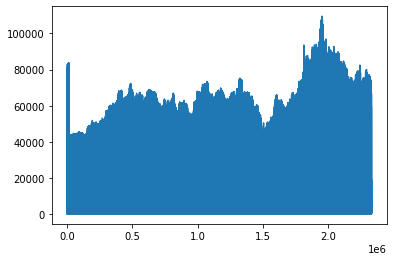

In [8]:
import matplotlib.pyplot as plt
plt.plot(df['Close'])

**The graph seen above is quite incomprehensible.**

**We need to calculate the adjusted close price by multiplying the ajustment factor with "Close" value.**

In [9]:

from decimal import ROUND_HALF_UP, Decimal
def adjusted_price(price):
    price.loc[:, "Date"] = pd.to_datetime(price.loc[:, "Date"], format = "%Y-%m-%d")
    
    def generated_close(df):
        df = df.sort_values("Date", ascending=False)
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        df = df.sort_values("Date")
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generated_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

**As, I have added this new column, which is adjusted close value, and it must be taken as an input to train my neural network.**

In [10]:
df = adjusted_price(df)

In [11]:
df.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,AdjustedClose
Date,,,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,1.0,2742.0
2017-01-05,20170105_1301,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,1.0,2738.0
2017-01-06,20170106_1301,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,1.0,2740.0
2017-01-10,20170110_1301,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,1.0,2748.0
2017-01-11,20170111_1301,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,1.0,2745.0


In [12]:
len(df)

2332531

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 13 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   RowId                       object 
 1   SecuritiesCode              int64  
 2   Open                        float64
 3   High                        float64
 4   Low                         float64
 5   Close                       float64
 6   Volume                      int64  
 7   AdjustmentFactor            float64
 8   ExpectedDividend            float64
 9   SupervisionFlag             bool   
 10  Target                      float64
 11  CumulativeAdjustmentFactor  float64
 12  AdjustedClose               float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 233.6+ MB


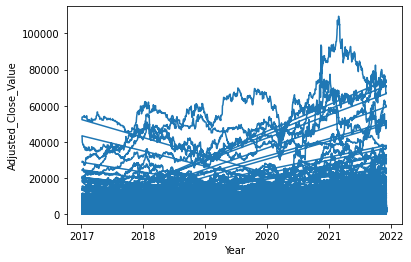

In [14]:
plt.plot(df["AdjustedClose"])
plt.ylabel("Adjusted_Close_Value")
plt.xlabel("Year")
plt.show()

In [15]:
len(df["AdjustedClose"])

2332531

**To make the graph more clear, and to determine the rise and fall of stock prices, clearly on the graph. I have taken only 100 adjusted Close prices. The graph can be seen below.**

In [16]:
dataset = df["AdjustedClose"]
len(dataset)

2332531

In [17]:
df1 = dataset[:100]

In [18]:
len(df1)

100

In [19]:
df1

Date
2017-01-04    2742.0
2017-01-05    2738.0
2017-01-06    2740.0
2017-01-10    2748.0
2017-01-11    2745.0
               ...  
2017-05-24    3175.0
2017-05-25    3130.0
2017-05-26    3080.0
2017-05-29    3065.0
2017-05-30    3025.0
Name: AdjustedClose, Length: 100, dtype: float64

**I have defined the number of 100 datas to influence the future stock prices.** **It is clearly seen that the length of the values is more than permssible, as training of the data might strain the computer. So we need to divide the values into more permissible amount and also further divide them into train set and test set**.

In [20]:
df1.isnull().sum()

0

**Importing the important Packages, that are needed.**

In [21]:
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Activation, Dropout
import seaborn as sns

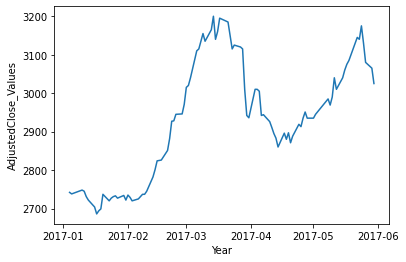

In [22]:
plt.plot(df1)
plt.ylabel("AdjustedClose_Values")
plt.xlabel("Year")
plt.show()

**Since, there are large number of datasets, it will be quite straining and time consuming task to fit and run the whole model by taking these large number of close values. So, I have taken only 200000 values, which could be used for my model training process.**

In [23]:
df2 = dataset[:200000]
len(df2)

200000

In [24]:
df2

Date
2017-01-04    2742.0
2017-01-05    2738.0
2017-01-06    2740.0
2017-01-10    2748.0
2017-01-11    2745.0
               ...  
2017-08-09    3655.0
2017-08-10    3695.0
2017-08-14    3705.0
2017-08-15    3815.0
2017-08-16    3770.0
Name: AdjustedClose, Length: 200000, dtype: float64

<AxesSubplot:xlabel='Date'>

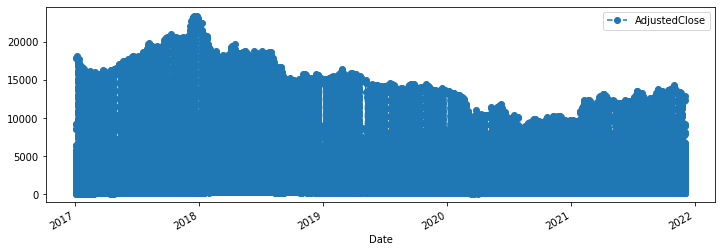

In [25]:
df2.plot(figsize=(12, 4), legend=True, linestyle="--", marker="o")

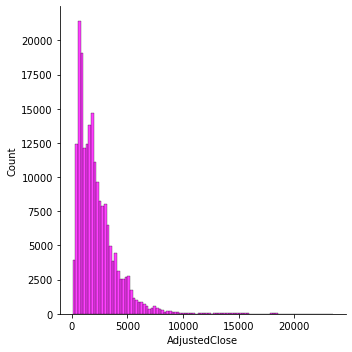

In [26]:
sns.displot(df2, bins=100, color='magenta')

**We keep the whole values between 0 and 1, by using the MinMaxScaler**


In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1, 1))

In [28]:
print(df2)

[[0.11339526]
 [0.11322388]
 [0.11330957]
 ...
 [0.15465561]
 [0.15936863]
 [0.15744057]]


In [29]:
train_size = int(len(df2)*0.75)
test_size = len(df2)-train_size
train_data, test_data = df2[0:train_size, :], df2[train_size:len(df2), :1]

**Here, I have taken time step as 100, and we have to train the model by taking the 100 inputs to the 101 as output, and the process continues for 200000 datas. The whole model is developed in this way to predict the another time step stock close value.**

In [30]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [32]:
print(X_train.shape)

(149899, 100)


In [33]:
print(y_train.shape)

(149899,)


In [34]:
print(X_test.shape)

(49899, 100)


In [35]:
print(X_train)

[[0.11339526 0.11322388 0.11330957 ... 0.12787708 0.1272344  0.12552057]
 [0.11322388 0.11330957 0.11365233 ... 0.1272344  0.12552057 0.12680594]
 [0.11330957 0.11365233 0.1135238  ... 0.12552057 0.12680594 0.12680594]
 ...
 [0.04075905 0.03875816 0.03875816 ... 0.06746474 0.06674922 0.05675333]
 [0.03875816 0.03875816 0.04082761 ... 0.06674922 0.05675333 0.05675333]
 [0.03875816 0.04082761 0.04118751 ... 0.05675333 0.05675333 0.05661194]]


In [36]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [37]:
X_train.shape

(149899, 100, 1)

**Multi Step LSTM is used in the following order as shown below.**

In [38]:
model_1 = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(100, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.1),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dropout(0.1),
    Dense(1)
])

2022-06-27 18:17:14.608004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 18:17:14.765866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 18:17:14.766594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 18:17:14.768761: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [39]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0

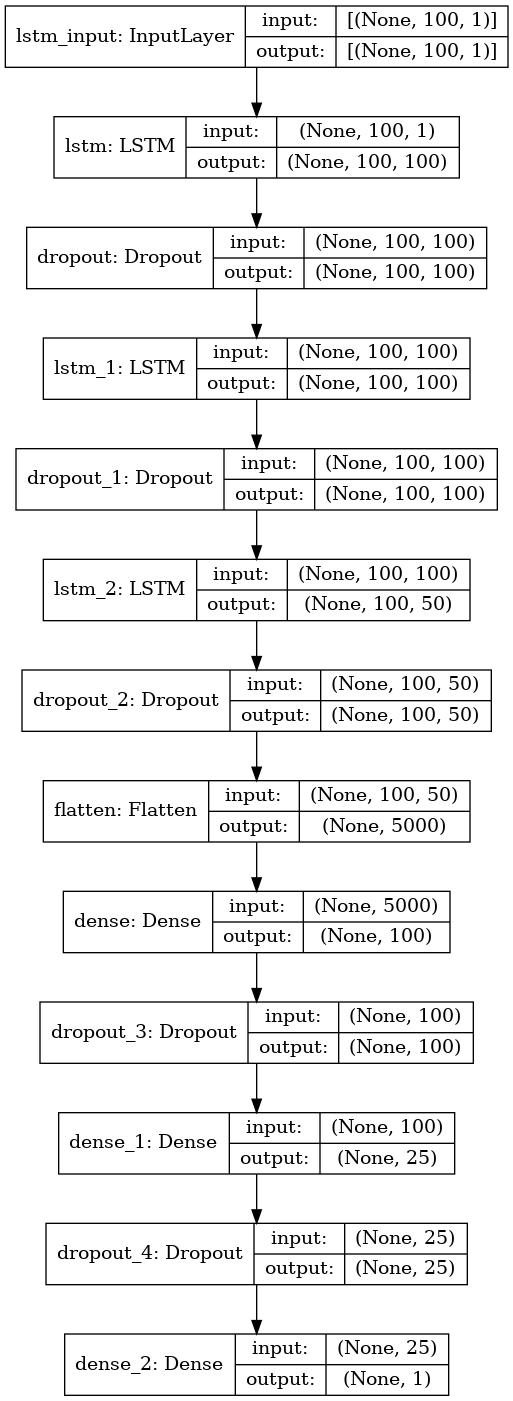

In [40]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, 'model_1.jpg', show_shapes=True)

In [41]:
model_1.compile(optimizer="adam", loss="mean_squared_error")

In [42]:
history_1 = model_1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

2022-06-27 18:17:19.832535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-27 18:17:24.058453: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4685/4685 [==============================] - 87s 17ms/step - loss: 5.8311e-04 - val_loss: 1.0023e-04
Epoch 2/10
4685/4685 [==============================] - 80s 17ms/step - loss: 3.2835e-04 - val_loss: 7.7557e-05
Epoch 3/10
4685/4685 [==============================] - 80s 17ms/step - loss: 2.5947e-04 - val_loss: 8.3583e-05
Epoch 4/10
4685/4685 [==============================] - 80s 17ms/step - loss: 2.4461e-04 - val_loss: 1.0809e-04
Epoch 5/10
4685/4685 [==============================] - 80s 17ms/step - loss: 2.1983e-04 - val_loss: 4.8439e-05
Epoch 6/10
4685/4685 [==============================] - 80s 17ms/step - loss: 2.1461e-04 - val_loss: 2.1056e-04
Epoch 7/10
4685/4685 [==============================] - 82s 17ms/step - loss: 1.9970e-04 - val_loss: 1.3250e-04
Epoch 8/10
4685/4685 [==============================] - 81s 17ms/step - loss: 1.9202e-04 - val_loss: 8.0123e-05
Epoch 9/10
4685/4685 [==============================] - 81s 17ms/step - loss: 1.9091e-04 - val_loss: 2.1750e-04
Epo

In [43]:
loss = model_1.evaluate(X_test, y_test)

1560/1560 [==============================] - 10s 7ms/step - loss: 1.6435e-04


<AxesSubplot:>

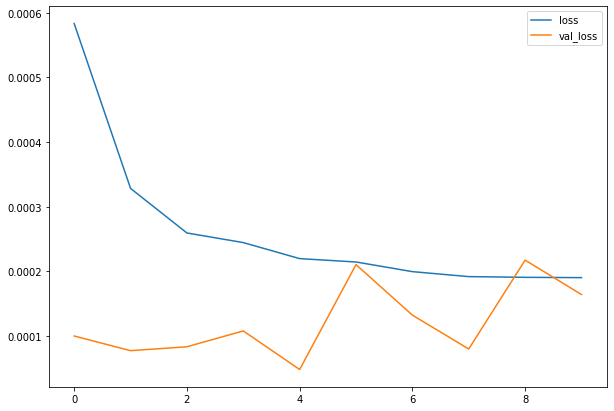

In [44]:
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10, 7))

**The loss obtained from the given model is as shown below.**

In [45]:
print(f"Loss of the model is: {loss*100}%.")

Loss of the model is: 0.016434503777418286%.


**The loss calculated above is 0.0119 %, which is quite low.**

In [46]:
train_predict = model_1.predict(X_train)
test_predict = model_1.predict(X_test)


**I predicted the values for stock market using the model as shown above, and converted them back to the original values, by inverse transfrom of MinMaxScaler.**

In [47]:
train_p = scaler.inverse_transform(train_predict) 
test_p = scaler.inverse_transform(test_predict)

**I calculated the square root of mean squared error of predicted values and the real values, and found the mean squared error for train set is 2705.614 and test set is 3368.504.**

In [48]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_p))

2978.511001376351

In [49]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test, test_p))

3616.6243268566122

**Now, I have to test our model on test stock market. I have also calculated the adjusted close price of the given test dataset.**

In [50]:
dataset_test = "/kaggle/input/jpx-tokyo-stock-exchange-prediction"
test_file = "example_test_files/stock_prices.csv"
test_all_file = os.path.join(dataset_test, test_file)

In [51]:
df_t = pd.read_csv(test_all_file)
df_t.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False


In [52]:
df_t.tail()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag
3995,20211207_9990,2021-12-07,9990,526.0,535.0,524.0,535.0,57800,1.0,NaN,False
3996,20211207_9991,2021-12-07,9991,795.0,806.0,792.0,805.0,48500,1.0,NaN,False
3997,20211207_9993,2021-12-07,9993,1640.0,1640.0,1620.0,1620.0,6600,1.0,NaN,False
3998,20211207_9994,2021-12-07,9994,2437.0,2440.0,2423.0,2440.0,5200,1.0,NaN,False
3999,20211207_9997,2021-12-07,9997,711.0,719.0,706.0,719.0,204500,1.0,NaN,False


In [53]:
len(df_t)

4000

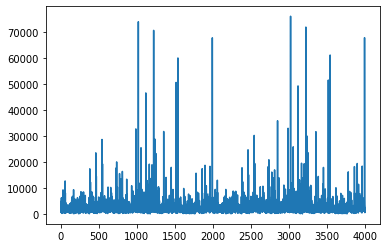

In [54]:
plt.plot(df_t['Close'])

In [55]:
df_t = adjusted_price(df_t)

In [56]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4000 entries, 2021-12-06 to 2021-12-07
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RowId                       4000 non-null   object 
 1   SecuritiesCode              4000 non-null   int64  
 2   Open                        3990 non-null   float64
 3   High                        3990 non-null   float64
 4   Low                         3990 non-null   float64
 5   Close                       3990 non-null   float64
 6   Volume                      4000 non-null   int64  
 7   AdjustmentFactor            4000 non-null   float64
 8   ExpectedDividend            0 non-null      float64
 9   SupervisionFlag             4000 non-null   bool   
 10  CumulativeAdjustmentFactor  4000 non-null   float64
 11  AdjustedClose               3992 non-null   float64
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 378.9+ KB


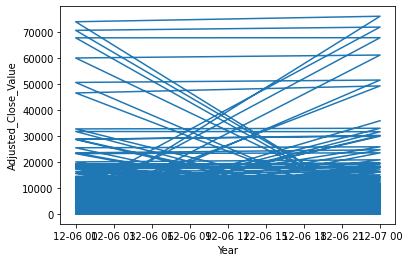

In [57]:
plt.plot(df_t["AdjustedClose"])
plt.xlabel("Year")
plt.ylabel("Adjusted_Close_Value")
plt.show()

**The graph is quite incomprehensible and I have taken only 1000 values, for prediction.**

In [58]:
df_t_1 = df_t[:1000]

In [59]:
df_t_1 = df_t_1.dropna()

In [60]:
df3 = df_t["AdjustedClose"][:1000]
len(df3)


1000

In [61]:
df3

Date
2021-12-06    2971.0
2021-12-07    3065.0
2021-12-06     589.0
2021-12-07     556.0
2021-12-06    2377.0
               ...  
2021-12-07    4575.0
2021-12-06    6550.0
2021-12-07    6790.0
2021-12-06    1916.0
2021-12-07    2006.0
Name: AdjustedClose, Length: 1000, dtype: float64

In [62]:
len(df3)

1000

In [63]:
df3.isnull().sum()

2

<AxesSubplot:xlabel='Date'>

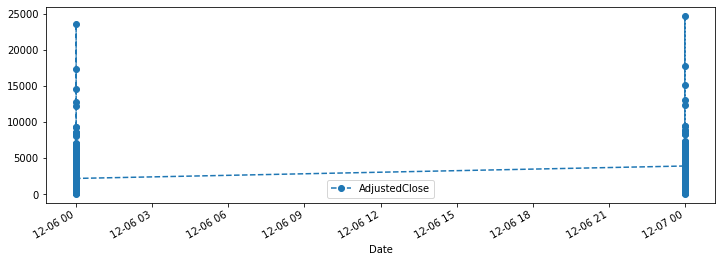

In [64]:
df3.plot(figsize=(12, 4), legend=True, linestyle="--", marker="o")

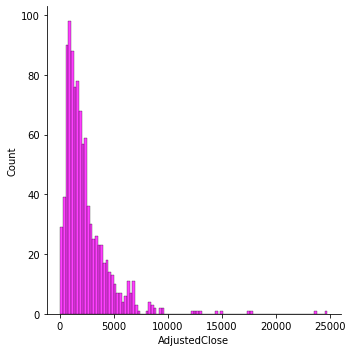

In [65]:
sns.displot(df3, bins=100, color="magenta")

In [66]:
df3

Date
2021-12-06    2971.0
2021-12-07    3065.0
2021-12-06     589.0
2021-12-07     556.0
2021-12-06    2377.0
               ...  
2021-12-07    4575.0
2021-12-06    6550.0
2021-12-07    6790.0
2021-12-06    1916.0
2021-12-07    2006.0
Name: AdjustedClose, Length: 1000, dtype: float64

In [67]:
df3 = df3.dropna()

In [68]:
len(df3)

998

In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df3 = scaler.fit_transform(np.array(df3).reshape(-1, 1))

In [70]:
time_step = 100
X_test_1, y_test_1 = create_dataset(df3, time_step)
X_test_1

array([[0.11805753, 0.12187107, 0.02142075, ..., 0.12998499, 0.09241754,
        0.09570368],
       [0.12187107, 0.02142075, 0.02008195, ..., 0.09241754, 0.09570368,
        0.21213842],
       [0.02142075, 0.02008195, 0.09395919, ..., 0.09570368, 0.21213842,
        0.2149783 ],
       ...,
       [0.02466632, 0.025356  , 0.01695809, ..., 0.02965638, 0.17846566,
        0.18313116],
       [0.025356  , 0.01695809, 0.01760721, ..., 0.17846566, 0.18313116,
        0.26325612],
       [0.01695809, 0.01760721, 0.0387034 , ..., 0.18313116, 0.26325612,
        0.27299282]])

In [71]:
X_test_1.shape

(897, 100)

In [72]:
X_test_1 = X_test_1.reshape(X_test_1.shape[0], X_test_1.shape[1], 1)

In [73]:
X_test_1.shape

(897, 100, 1)

In [74]:
test_predict_1 = model_1.predict(X_test_1)

In [75]:
test_p_1 = scaler.inverse_transform(test_predict_1)

In [76]:
y_test_1 = y_test_1.reshape(897,1)

In [77]:
test_p_1.shape

(897, 1)

**Square root mean squared error is found to be 3094.5207 on the test values for stock price prediction.**

In [78]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test_1, test_p_1))

3033.7422072803292

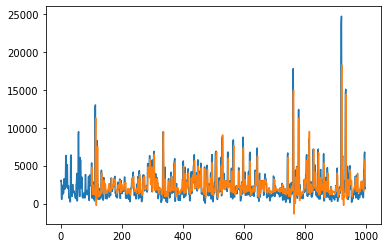

In [79]:
import numpy as np
back = 100

testPredictPlot = np.empty_like(df3)
testPredictPlot[:, :] = np.nan
testPredictPlot[back:len(test_p_1)+back, :] = test_p_1


plt.plot(scaler.inverse_transform(df3))
plt.plot(testPredictPlot)
plt.show()

In [80]:
test_p_1 = np.squeeze(test_p_1)

In [81]:
test_p_1 = pd.DataFrame(test_p_1, columns = ['Stock_Price'])

In [82]:
test_p_1.shape

(897, 1)

In [83]:
test_p_1 = np.squeeze(test_p_1)

In [84]:
test_p_1

0      2510.767822
1      4506.718750
2      4794.649414
3      2002.370728
4      1214.816406
          ...     
892    1656.098755
893    3213.313965
894    4113.562500
895    4881.371582
896    5812.257812
Name: Stock_Price, Length: 897, dtype: float32

In [85]:
my_submission = pd.DataFrame({'Id': df_t_1.SecuritiesCode, 'Stock_Price': test_p_1})
my_submission.to_csv('my_submission.csv', index=False)

# **"model_1" is the trained model with very low losses and high accuracy, you could use that to predict your stock prices.**